# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [2]:
datagen = ImageDataGenerator(rescale=1./255)

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


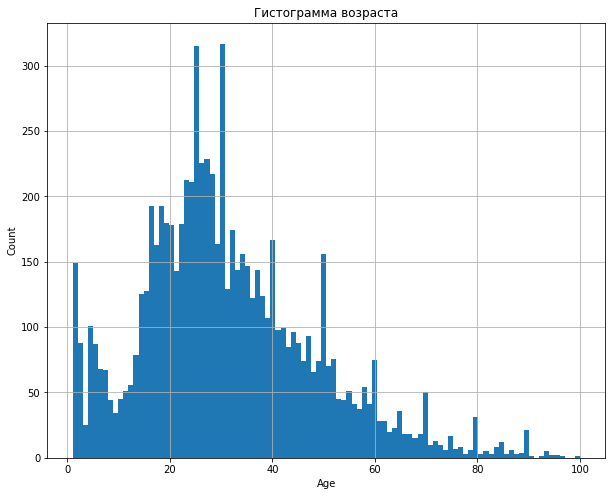

In [6]:
plt.figure(figsize=(10,8))
labels['real_age'].hist(bins=100)
plt.title('Гистограмма возраста')
plt.xlabel('Age')
plt.ylabel('Count');

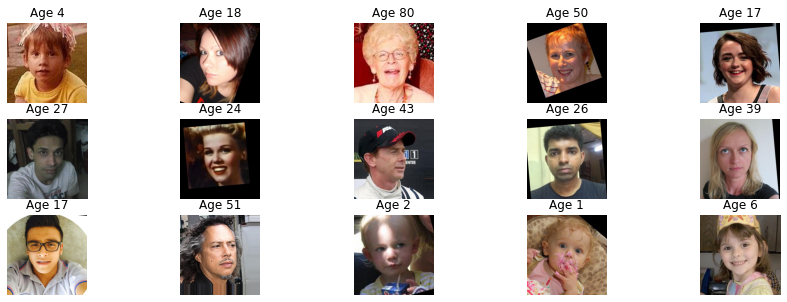

In [7]:
pic_box = plt.figure(figsize=(15,5))

for i in range(15):
    image = Image.open('/datasets/faces/final_files/' + labels.iloc[i][0])
    pic_box.add_subplot(3,5,i+1)
    plt.imshow(np.array(image))
    plt.title('Age '+ str(labels.iloc[i][1]))
    plt.axis('off')
plt.show()   

1. Набор данных представлен 7591 фотографией и значением реального возраста
1. Значение возраста в диапазоне от 1 до 100
1. Распределение возраста в наборе данных смещено влево, больше всего значений от 20 до 40, так же много значений от 0 до 10
1. На фотографиях представленны голова и ингода верхняя часть тела, лица не всегда видны полностью, иногда они повернуты и/или частично перекрываются одеждой, волосами или другими частями тела

## Обучение модели

Код в этом разделе запускается в отдельном GPU, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке

```python
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd

def load_train(path):

    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25, horizontal_flip=True)

    labels = pd.read_csv('/datasets/faces/labels.csv')

    train_datagen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory='/datasets/faces/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='training',
            seed=12345) 

    return train_datagen_flow


def load_test(path):

    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

    labels = pd.read_csv('/datasets/faces/labels.csv')

    test_datagen_flow = test_datagen.flow_from_dataframe(
            dataframe=labels,
            directory='/datasets/faces/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw', 
            subset='validation',
            seed=12345) 

    return test_datagen_flow



def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(units=1 , activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=len(train_data),
              validation_steps=len(test_data),
              verbose=2)

    return model
```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/5
178/178 - 58s - loss: 241.9248 - mae: 11.0931 - val_loss: 1049.3797 - val_mae: 27.7603
Epoch 2/5
178/178 - 46s - loss: 76.5049 - mae: 6.6187 - val_loss: 675.1400 - val_mae: 20.5737
Epoch 3/5
178/178 - 48s - loss: 48.8085 - mae: 5.2796 - val_loss: 255.0443 - val_mae: 12.3564
Epoch 4/5
Epoch 5/5
178/178 - 48s - loss: 37.7234 - mae: 4.6274 - val_loss: 113.8728 - val_mae: 8.0846
178/178 - 48s - loss: 28.0811 - mae: 4.0296 - val_loss: 80.9595 - val_mae: 6.8414

60/60 - 11s - loss: 80.9595 - mae: 6.8414
Test MAE: 6.8414
```

## Анализ обученной модели

1. Для обучения применялась библиотека tensorflow и API Keras
1. Данные загрузки и предобработки данны использовался загрузчик ImageDataGenerator, ему были переданы аргументы для выделения тестовой выборки и приведения яркости к значениям в диапазоне от 0 до 1. С помощью метода flow_from_dataframe были загруженны и объеденены фото и данные о возрасти из набора данных. Так же была создана тестовая выборка для чего использовался повоторый вызов загрузчика и передача методу flow_from_dataframe значения аргумента seed равного значения значению seed для тренировочной выборки
1. Для обучения модели была адаптирована ResNet50, и к ней добавлены пулинг с окном во весь тензор
1. На выходе модели полносвязный слой с одним нейроном
1. Модель оптимизировалась по средней абсолютной ошибке. Для улучшения минимизации функции потерь использовался оптимизатор Adam 
1. Обучение заняло 5 эпох, значение MAE на тестовой выборке = 6.9874 - соответствует требованию задачи